In [1]:
import numpy as np
from traj_opt import TrajOpt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
from humanoid_grab_task import humanoid_grab_task as Task

%load_ext autoreload
%autoreload 2

In [2]:
task = Task()
to = TrajOpt(task.ndof)

In [3]:
#task.q_0 = np.array([1.28120593, 0.60490846, -1.92783999, -2.9305852, 1.24061034])
#task.q_0 = np.array([0.46412239, 2.74187294, -1.59068688, -0.06929162, 2.99044704])
task.q_0 = np.array([1.4, 0.3, -0.1, -3.0, 0.4])

### Sequential least-squares quadratic programming

In [4]:
def fun(p):
    w = np.concatenate((task.q_0, p, np.zeros(2*task.ndof)))
    return task.alpha_control * task.control_cost(w)

def target_con_p(p):
    q = task.Phi[-task.ndof:] @ np.concatenate((task.q_0, p, np.zeros(2*task.ndof)))
    return np.concatenate((task.fk(q)[-1] - task.x_des[:2], [np.sum(q) - task.x_des[2]]))

def com_con_p(p):
    q_traj = (task.Phi @ np.concatenate((task.q_0, p, np.zeros(2*task.ndof)))).reshape(len(task.t_cost_array), task.ndof)
    com_x = np.zeros_like(task.t_cost_array)
    for i in range(len(task.t_cost_array)):
        com_x[i] = task.CoM(q_traj[i])[0]
    return com_x

def com_con_T_p(p):
    return task.CoM_T(task.Phi[-task.ndof:] @ np.concatenate((task.q_0, p, np.zeros(2*task.ndof))))[0]

def CoM_con(w):
    q_traj = (Phi @ w).reshape(len(t_cost_array), ndof)
    err = np.zeros_like(t_cost_array)
    for i in range(len(t_cost_array)):
        com_x = CoM(q_traj[i])[0]
        err[i] = np.max([0.0, - com_x, com_x-foot_length])
    return err

In [5]:
def run_opt(num_basis):
    nw = num_basis + 3
    num_via = num_basis
    h = task.T * np.ones(num_via) / num_via
    to.setup_task(h)

    Phi = to.get_Phi(task.t_cost_array)
    dPhi = to.get_dPhi(task.t_cost_array)
    ddPhi = to.get_ddPhi(task.t_cost_array)

    task.set_basis(Phi, dPhi, ddPhi)

    Xi = np.zeros((nw*task.ndof, num_basis*task.ndof))
    Xi[task.ndof:-2*task.ndof] = np.eye(num_basis*task.ndof)

    def grad(p):
        w = np.concatenate((task.q_0, p, np.zeros(2*task.ndof)))
        return (task.alpha_control * task.control_grad(w)) @ Xi

    K = len(task.t_cost_array)
    
    q_min = np.zeros(task.ndof*num_basis)
    q_max = np.zeros(task.ndof*num_basis)
    for i in range(task.ndof):
        q_min[i::task.ndof] = task.q_min[i] * np.ones(num_basis)
        q_max[i::task.ndof] = task.q_max[i] * np.ones(num_basis)

    constraints = []
    constraints.append(LinearConstraint(np.eye(num_basis*task.ndof), q_min, q_max))
    constraints.append(NonlinearConstraint(target_con_p, -1e-3, 1e-3))
    constraints.append(NonlinearConstraint(com_con_p, 0.0, task.foot_length))
    constraints.append(NonlinearConstraint(com_con_T_p, 0.0, task.foot_length))

    p_init = np.zeros(num_basis*task.ndof)
    for i in range(num_basis):
        p_init[i*task.ndof:(i+1)*task.ndof] = task.q_0 + np.random.normal(0, 0, task.ndof)

    start = time.time()
    res = minimize(fun, p_init, method='SLSQP', jac=grad, bounds=None, constraints=constraints, options={'maxiter': 1000, 'ftol': 1e-6, 'disp': False})
    duration = time.time()-start
    print("Elapsed time: ", duration," [s]")
    return res.success, res.fun, np.concatenate((task.q_0, res.x, np.zeros(2*task.ndof))), duration

In [6]:
success = False
num_basis = 1
beta = 1.5
T = 0
while not success and num_basis < 15:
    print(num_basis)
    success, f, w_opt, duration = run_opt(num_basis)
    num_basis = int(np.ceil(num_basis*beta))
    T += duration

print(success, f, T)

1
Elapsed time:  0.41363024711608887  [s]
True 0.027372486589860592 0.41363024711608887


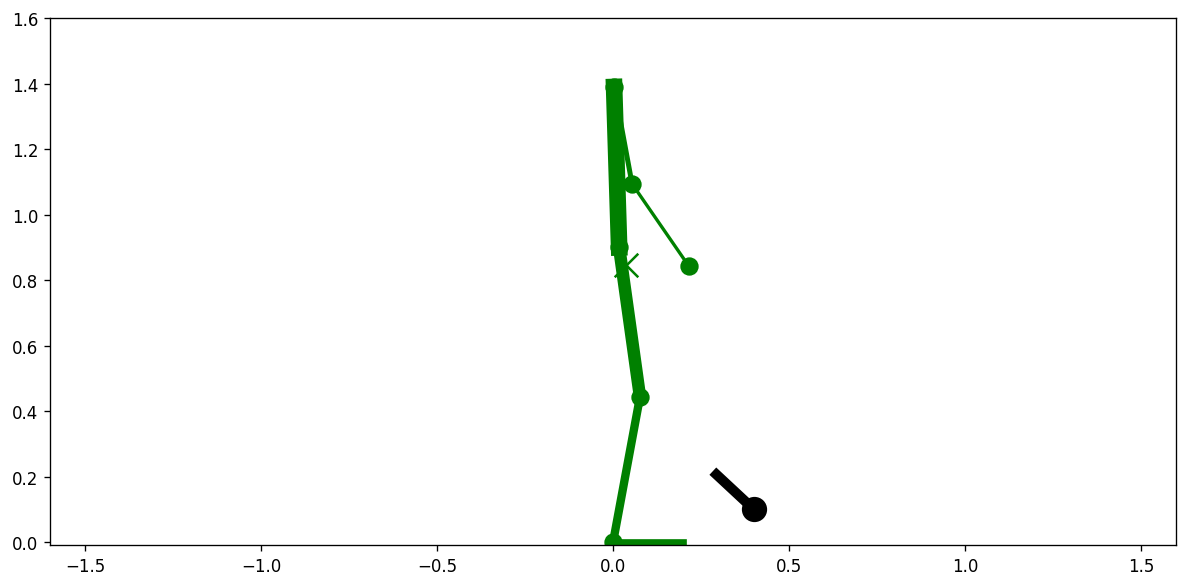

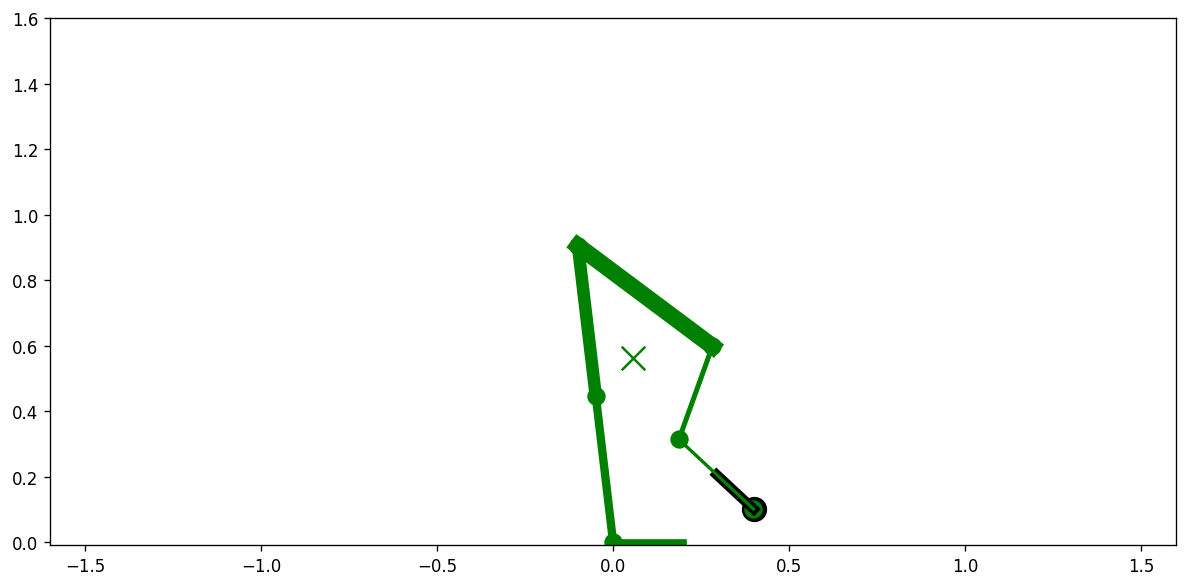

In [7]:
task.plot_environment(task.q_0)
task.plot_environment(task.Phi[-task.ndof:] @ w_opt)

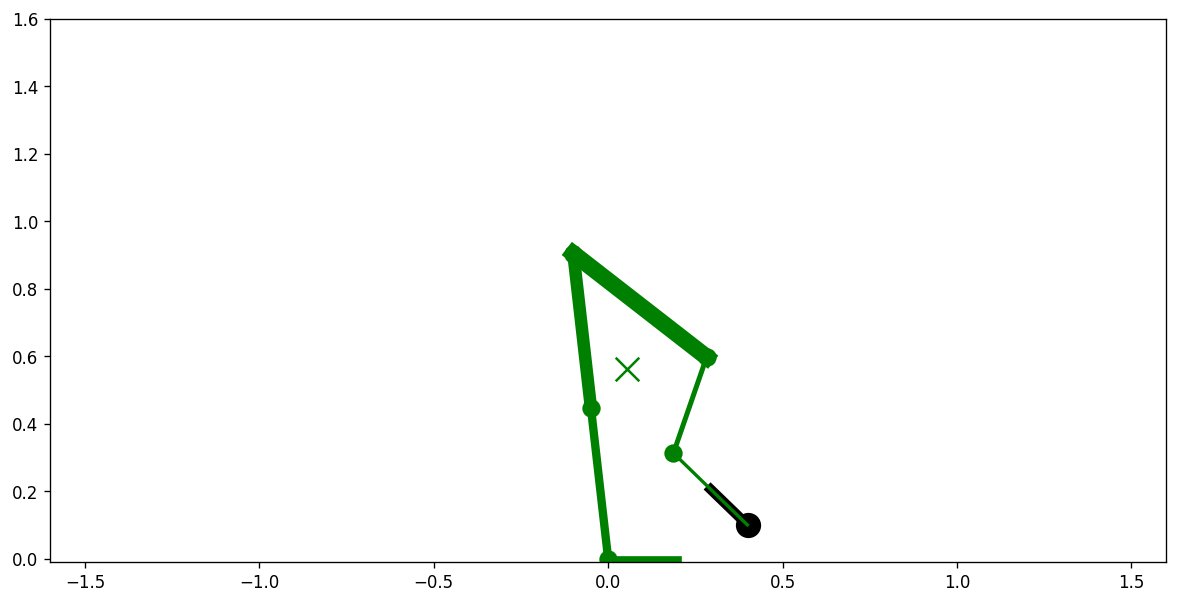

In [8]:
q = (to.get_Phi(np.linspace(0, task.T, int(task.T/0.04))) @ w_opt).reshape(int(task.T/0.04), task.ndof)
task.save_animation(q)